In [11]:
import numpy as np
import pandas as pd
import re as re
from nltk.corpus import stopwords
from nltk.stem.porter import *
import translators as ts
import unicodedata
from langdetect import detect
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
#import nltk
from PIL import Image
from wordcloud import WordCloud
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/macbook/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_json('NORA_grants_export_1.lst', lines=True)  #reading in the data
df.amount = df.amount.astype(int) # converting currency as integer

#check is all currency written in DKK? 
currency_check = df.currency != "DKK"
print("rows written in currency other than DKK : ",len(df.currency[currency_check]))

print(df.columns)
print("shape of loaded dataset : ", df.shape)


nmask = df.pubs.notnull()

df.loc[nmask].pubs.iloc[1]

nmask = df.pubs.notnull()

df.loc[nmask]

rows written in currency other than DKK :  0
Index(['abstract', 'amount', 'currency', 'date', 'doi', 'dst', 'filters',
       'funder', 'id', 'keyword', 'oecd', 'opencomp', 'org', 'person', 'title',
       'type', 'year', 'green', 'pubs', 'call', 'url'],
      dtype='object')
shape of loaded dataset :  (8330, 21)


,abstract,amount,currency,date,doi,dst,filters,funder,id,keyword,...,opencomp,org,person,title,type,year,green,pubs,call,url
319,Under mit forskningsophold ved Janet Currie på...,281160,DKK,"{'end': '2024-06-30', 'start': '2024-01-01'}",10.46540/3126-00006B,"{'code': 0, 'instrument': 'Research Projects (...","{'amount': ['<00.1-00.5>0.1-0.5 MDKK'], 'amoun...","{'crossref': '501100004836', 'cvr': '34042012'...",3126-00006A,"[children, mental health, sibling spillovers]",...,Yes,"[{'affno': 1, 'country': 'dk', 'cvr': '2997981...","[{'affno': 1, 'name': {'first': 'Nezahat Melte...","Child Disability, Sibling Mental Health, and t...",grant,2023,NaN,[{'title': 'Child Disability and Sibling Menta...,NaN,NaN
320,NaN,214632,DKK,"{'end': '2023-12-20', 'start': '2023-08-20'}",10.46540/3126-00011B,"{'code': 0, 'instrument': 'Research Projects (...","{'amount': ['<00.1-00.5>0.1-0.5 MDKK'], 'amoun...","{'crossref': '501100004836', 'cvr': '34042012'...",3126-00011A,"[Biodiversity loss, Inequality aversion, Socia...",...,Yes,"[{'affno': 1, 'country': 'dk', 'cvr': '2997981...","[{'affno': 1, 'name': {'first': 'Frikk Hugo Bø...",Social welfare and long-term policies,grant,2023,"[{'code': '06', 'dst': 'Nature Conservation, B...",[{'title': 'Intergenerational Discounting and ...,NaN,NaN
403,Forekomsten af nærsynethed er stigende i hele ...,505915,DKK,"{'end': '2024-05-31', 'start': '2024-02-01'}",10.46540/3165-00039B,"{'code': 0, 'instrument': 'Research Projects (...","{'amount': ['<00.5-01.0>0.5-1 MDKK'], 'amounts...","{'crossref': '501100004836', 'cvr': '34042012'...",3165-00039A,"[Short-term choroidal fluctuations, Myopia con...",...,Yes,"[{'affno': 1, 'country': 'dk', 'cvr': '2919090...","[{'affno': 1, 'name': {'first': 'Flemming', 'f...",The Immediate effect of Defocus spectacles On ...,grant,2023,NaN,[{'title': 'The Immediate effect of Defocus in...,NaN,NaN
909,Sea level rise is one of the most dangerous ri...,41791111,DKK,"{'end': '2029-08-31', 'start': '2023-09-01'}",NaN,"{'code': '24', 'instrument': 'Research Project...","{'amount': ['<10.0-50.0>10-50 MDKK'], 'amounts...","{'crossref': '501100009708', 'cvr': '10582989'...",NNF23OC0081251,NaN,...,No,"[{'affno': 1, 'country': 'dk', 'cvr': '2997981...","[{'affno': 1, 'name': {'first': 'Christine Sch...",PRECISE - PREdiction of Ice Sheets on Earth,Award,2023,NaN,"[{'dimid': 'pub.1165750556', 'doi': '10.1017/j...",Challenge Programme 2023 – Prediction of Clima...,NaN
912,NaN,7654127,DKK,"{'end': '2027-04-30', 'start': '2023-05-01'}",NaN,"{'code': '32', 'instrument': 'Research Project...","{'amount': ['<05.0-10.0>5-10 MDKK'], 'amountso...","{'crossref': '501100009708', 'cvr': '10582989'...",NNF23OC0081371,NaN,...,Yes,"[{'affno': 1, 'country': 'dk', 'cvr': '2997981...","[{'affno': 1, 'name': {'first': 'Morten', 'ful...",Collaborative Courageous Science,Award,2023,NaN,"[{'dimid': 'pub.1160813199', 'doi': '10.1145/3...",Novo Nordisk Foundation LIFE Research Initiati...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8300,"USA har lanceret et revolutionært program, Def...",206496,DKK,"{'end': '2017-06-30', 'start': '2017-01-01'}",10.46540/6165-00003B,"{'code': '36', 'instrument': 'Research Project...","{'amount': ['<00.1-00.5>0.1-0.5 MDKK'], 'amoun...","{'crossref': '501100004836', 'cvr': '34042012'...",6165-00003A,"[Military change, Alliances, Innovation pathwa...",...,Yes,"[{'affno': 1, 'country': 'dk', 'cvr': '2928395...","[{'affno': 1, 'name': {'first': 'Sten', 'full'...",Military Innovation and U.S. Leadership in NATO,grant,2016,NaN,"[{'eissn': '0162-2889', 'title': 'Rise and Dec...",NaN,NaN
8301,Udvikling og anvendelse af IT har vidtrækkende...,65051,DKK,"{'end': '2017-07-01', 'start': '2017-01-01'}",10.46540/6165-00006B,"{'code': '38', 'instrument': 'Research Project...","{'amount': ['<00.0-00.1>0-0.1 MDKK'], 'amounts...","{'crossref': '501100004836', 'cvr': '34042012'...",6165-00006A,"[Innovation, Digitization, IT, Digital innovat...",...,Yes,"[

In [4]:
#Chapter 1 - result printer functions

def grant_counter(start_year, end_year, df_1, text):
    
    """
    this function produces the bar plot, showing the distribution of the grant entity count pr year
    
    input:
    
    year_start: distribution start year
    year_end : distribution end year
    df : df target
    text: Title of plot
    
    """

    years = np.arange(start_year, end_year, 1)
    data_grant_counts = []

    for i in years:
        grouped_years = df_1[df_1[('start_year')] == i] # finding the year
        counts = grouped_years.groupby([grouped_years[('foundation')], grouped_years[('start_year')]])["amount"].count()
        data_grant_counts.append(counts.sum())

    plt.bar(years, data_grant_counts)
    plt.title("Annual grant entity count")
    plt.xlabel('Year')
    plt.ylabel('Grants')
    for i, value in enumerate(data_grant_counts):
        plt.text(years[i], value, f'{value}', ha='center', va='bottom', fontsize=8)
    #plt.savefig(f"plots_2_12/number_of_grants_alldata_{text}.jpg")
    plt.show()
    return

def grant_sum_fund_sum(start_year, end_year, df, text):
    
    """
    this function produces the bar plot, showing the distribution of foundationwise contribution pr year
    
    input:
    
    year_start: distribution start year
    year_end : distribution end year
    df : df target
    text: Title of plot
    
    """
    
    years = np.arange(start_year, end_year, 1)
    full_data = []
    data_grant_sum = []
    data_number_of_foundations = []

    for i in years:
        grouped_years = df[df[('start_year')] == i]  #Finding year 
        grouped = grouped_years.groupby([grouped_years[('foundation')], grouped_years[('start_year')]])["amount"].sum()
        data_grant_sum.append(grouped.sum())
        full_data.append(grouped)
        data_number_of_foundations.append(grouped.shape[0])
        
    
    
    df = pd.DataFrame(pd.concat(full_data))
    df = df.reset_index()
    df_pivot = df.pivot(index='start_year', columns='foundation', values='amount').fillna(0)
    df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20') # stacked bar chart

    #adding labels
    plt.ylabel('Grant_size_(DKK)')
    plt.title('Summed Grant Sizes pr. Year (Number of foundations in dataset)')
    axis_labels = plt.gca()  
    plt.legend(title='Foundation', bbox_to_anchor=(1.05, 1), loc='upper left')
    axis_labels.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, position: f'{x / 1e9:.0f} Billion'))

    for i, total in enumerate(data_number_of_foundations):
        bar_height = df_pivot.iloc[i].sum() / 2  #stacked bar center for position at the center of the bar
        plt.text(i, bar_height,  #position at the center of the bar
                 f'({total:,})', ha='center', va='center', fontweight='bold', color='white')

    plt.tight_layout()
    #plt.savefig(f"plots_2_12/sums_and_number_combined{text}.jpg")
    plt.show()
    return


def pr_foundation_grantsum(df):
    
    fund_names = df["foundation"].unique()
    
    for fund_name in fund_names:
        data_grant_sum = []
        data_number_of_foundations = []
        full_data = []
        data_grant_counts = []
        i_fundnames = df[df[('foundation')] == fund_name]  #Find fundname
        years = np.arange(i_fundnames["start_year"].min(), i_fundnames["start_year"].max(), 1)

        for s in years:
            grouped_years = i_fundnames[i_fundnames[('start_year')] == s]  #Finding year 
            grouped = grouped_years.groupby([grouped_years[('foundation')], grouped_years[('start_year')]])["amount"].sum()
            data_grant_sum.append(grouped.sum())
            counts = grouped_years.groupby([grouped_years[('foundation')], grouped_years[('start_year')]])["amount"].count()
            data_grant_counts.append(counts.sum())


        plt.bar(years, data_grant_sum)
        plt.title(f"Annual grant SUM (DKK) - {fund_name}")
        plt.xlabel('Year')
        plt.ylabel('DKK')
        axis_labels = plt.gca() 
        axis_labels.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x / 1e6:.0f} Million'))
        axis_labels.set_xticks(years, labels=years, rotation = "vertical", fontsize=8)

        plt.show()
        


        plt.bar(years, data_grant_counts)
        plt.title(f"Annual grant entity count - {fund_name}")
        plt.xlabel('Year')
        plt.ylabel('Grants')
        for number, val in enumerate(data_grant_counts):
            plt.text(years[number], val, f'{val}', ha='center', va='bottom', fontsize=8)
        axis_setter = plt.gca()
        axis_setter.set_xticks(years, labels=years, rotation = "vertical", fontsize=8)
        plt.show()
    return

def means_and_median(start_year, end_year, df, text, text_if_outlier):
    
    years = np.arange(start_year, end_year, 1)

    errors = []
    medians = []
    means = []

    for year in years:
        grouped_years = df[df[('start_year')] == year]
        medians.append(grouped_years["amount"].median())
        means.append(grouped_years["amount"].mean())
        errors.append(grouped_years["amount"].std()/np.sqrt(len(grouped_years["amount"])))

    bar_width = 0.35
    index = np.arange(len(years))

    fig, ax = plt.subplots()

    bars1 = ax.bar(index, medians, bar_width, label='Median Grant Size (DKK)', color='blue')
    bars2 = ax.bar(index + bar_width, means, bar_width, label='Mean Grant Size (DKK)', color='orange', yerr=errors, ecolor = "red", capsize=3)

    ax.set_xlabel('Year')
    ax.set_ylabel('Grant Size (DKK)')
    ax.set_title(f'Median and Mean Grant Sizes (M) - {text_if_outlier}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(years)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x / 1e6:.1f} Million'))
    ax.legend()

    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval/ 1e6:.2f}', ha='center', va='bottom')

    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval/ 1e6:.2f}', ha='left', va='bottom')

    plt.tight_layout()
    #plt.savefig(f"plots_2_12/means_n_sums_{text}.jpg", bbox_inches = "tight")
    plt.show()
    
    return

def outlier_detecter(start_year, end_year, df):
    #outliers removed after defining the threshold with the upper quartile and the interquartile range: 
    #threshold = Q3+1.5*IQR
    outlier_list = []
    upper_bounds = []
    years = np.arange(start_year, end_year, 1)
    non_outliers_list = [] 
    for year in years:
        grouped_years = df[df['start_year'] == year]
        Q1 = np.percentile(grouped_years["amount"], 25, method='midpoint')
        Q3 = np.percentile(grouped_years["amount"], 75, method='midpoint')
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR  #upper boundary
        upper_bounds.append(upper)
        non_outliers = grouped_years[grouped_years["amount"] <= upper]  #filter out outliers
        outliers = grouped_years[grouped_years["amount"] >= upper]  #keep outliers
        print(f"{year} - Upper Bound: {upper}, Outliers removed Count: {len(outliers)}")
        outlier_list.append(outliers)
        non_outliers_list.append(non_outliers) # Appending non-outlier data to the list
    df_no_outliers = pd.concat(non_outliers_list, ignore_index=True)  #new df without outliers
    return df_no_outliers, outlier_list


def outlier_contributer_combined(out_list, text):
    combined_outliers = pd.concat([pd.DataFrame(i) for i in out_list], ignore_index=True)
    foundation_totals = combined_outliers.groupby("foundation")["amount"].sum()
    total_outliers = foundation_totals.sum()
    foundation_percentages = (foundation_totals / total_outliers) * 100
    plt.figure(figsize=(12, 8))
    foundation_percentages.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title("Percentage Contribution of Foundations to Outlier Grants (from year 2016-2025)")
    plt.xlabel("Foundation Name")
    plt.ylabel("Percentage of Total Outlier Grants (%)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    #plt.savefig(f"plots_2_12/outlier_contribute_{text}_combined.jpg")
    plt.show()
    return






# Translator functions




def detection_fun(raw_abstract):
    """
    this function takes a list of text strings as input, 
    detects the language of the string, 
    and saves it to a list returned
    """
    detection_list = []
    for num, i in enumerate(raw_abstract):
        if pd.notna(i):
            d = detect(i) 
            detection_list.append(d)
        else:
            detection_list.append(i) 
        if num % 100 == 0:
            print(num)
    return detection_list


def split_sentences(text):
    
    """
    This function splits an abstract into max 1000 characters, translates, and join them again
    to avoid translation limitations
    """
    
    sentences = []
    current_sentence = ""
    
    for next_sen in text.split(". "):  # Split abstract by . followed by a space
        if len(current_sentence + next_sen + ".") <= 1000:  # Checking if adding the next sentance exceeds 1000
            current_sentence += next_sen + ". "
        else:
            sentences.append(current_sentence.strip()) # If it exceeds, the current sentence is stored, and a new is initiated
            current_sentence = next_sen + ". "
    
    if current_sentence: # remaining sentence is appended to deal with the end
        sentences.append(current_sentence.strip())
    
    return sentences

def translater_function(df_abstract, index_to_ts):
    """
    This function takes a series object with text info that is to be translated. 
    It translates the text and saves the data to a new series object called translated_description
    """
    translated_description_list = []
    not_translated = []
    index = []

    for num, i in enumerate(df_abstract[index_to_ts]):  #Indication on how many lines have been translated
        if num % 100 == 0:
            print(num)
        
        try:
            if len(i) < 1000: #if len < 1000 translate and append to translated_description_list
                item = ts.translate_text(query_text=i, if_use_preacceleration = True, if_ignore_empty_query=True, translator='baidu')
                translated_description_list.append(item)
            elif len(i) > 999: #if len > 1000 translate split sentance in smaller bits, translate, and join them back
                list_of_sen = split_sentences(i)
                
                new_sentance = []
                for new_ts in list_of_sen:
                    item2 = ts.translate_text(query_text=new_ts, if_use_preacceleration = True, translator='baidu')
                    new_sentance.append(item2)
                    
                    
                translated_description_list.append(" ".join(new_sentance))

        except Exception as e:  #raise exception if the sentance was not translated, and save to list: not_translated
            print(f"Error translating: {e}")
            translated_description_list.append("SKIPPED_DUE_TO_ERROR")
            not_translated.append(i)
            index.append(num)
            print(num, i)
                
    return translated_description_list, not_translated, index


def language_abstract_detect_parser(lang_detect_list):
    
    """if the field is shorter than 50 characters it will not be included as this can not be an abstract"""

    abstract_translate_index = []
    no_abstract_index = []

    for num, i in enumerate(lang_detect_list):
        if i in [None, "nan", np.nan]:
            no_abstract_index.append(num)
        elif pd.isna(i) == True:
            no_abstract_index.append(num)
        else:
            if i != "en" and i == "da":
                abstract_translate_index.append(num)
            elif len(i) > 50:
                abstract_translate_index.append(num)
            else:
                no_abstract_index
            
    return abstract_translate_index, no_abstract_index

def language_title_detect_parser(lang_detect_list_title):

    no_title_index = []
    title_translate_index = []

    for num, i in enumerate(lang_detect_list_title):
        if pd.isna(i) == True:
            no_title_index.append(num)
        else:
            if i != "en":
                title_translate_index.append(num)
        
    return title_translate_index, no_title_index





#Data cleaning functions

def nfkd_normalize(text_string):
    """
    This function takes in a string and
    returns the string normalized in form: KD (Kompatibility Decomposition):
    NFKD
    
    eg. café -> cafe
    
    it also removes any special character
    
    """
    text_string = unicodedata.normalize('NFKD', text_string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text_string = re.sub(r'[^\w\s]', '', text_string).lower()
    return text_string

def removing_html_tags(text):
    """
    This function removes HTML tags in a given string (if it has one)
    
    input : text string
    return : modified text without HTML tag
    
    """
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', str(text))

def removing_url(text):
    """
    This function removes URLs in a given string (if it has one)
    
    input : text string
    return : modified text without URL
    
    """
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

def tokenize_fun(text_string):
    """
    This function takes in a string and returns the tokenized string via. NLTK library
    
    """
    tokenizer = nltk.tokenize.ToktokTokenizer()
    text_string = tokenizer.tokenize(text_string, return_str = True)

    return text_string

def stemming_fun(text_string):
    """
    This function takes a textstring as input and performs stemming -> returns string after stemming
    """
    
    out_string = []
    
    stemmer = PorterStemmer()

    for word in text_string.split():
        out_string.append(stemmer.stem(word))
    
    text_string = ' '.join(out_string)
    
    return text_string

def remove_stopwords(text_string, extra_words = [], exclude_words = []):
    """
    This function takes a text string as an input, removes stopwords and returns a string without.
    
    
    optional: extra_words and exclude_words lists with default empty lists
    
    """
    
    kept_words = []
    
    
    list_stopword = stopwords.words('english')

    list_stopword = set(list_stopword) - set(exclude_words)

    list_stopword = list_stopword.union(set(extra_words))

    words = text_string.split()

    for word in words:
        if word not in list_stopword:
            kept_words.append(word)

    string_wo_stopwords = ' '.join(kept_words)
    
    return string_wo_stopwords

def clean(text_string):
    """
    This function combines eack previous function and clean the text accordingly
    """
    return nfkd_normalize(stemming_fun(tokenize_fun(removing_url(removing_html_tags(remove_stopwords(text_string))))))

def clean_no_stem(text_string):
    """
    This function combines eack previous function and clean the text accordingly
    """
    return nfkd_normalize(tokenize_fun(removing_url(removing_html_tags(remove_stopwords(text_string)))))


#no stemming alteration
def clean_column(df):
    """
    Cleansing the 'abstract' column
    """
    
    df["cleaned_column"] = df["abstract"].dropna().apply(clean) 
    return df 

def clean_column_no_stem(df):
    """
    Cleansing the 'abstract' column
    """
    
    df["cleaned_column"] = df["abstract"].dropna().apply(clean_no_stem) 
    return df 






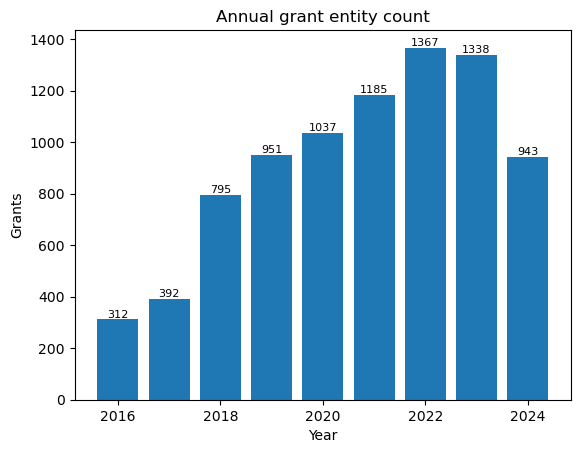

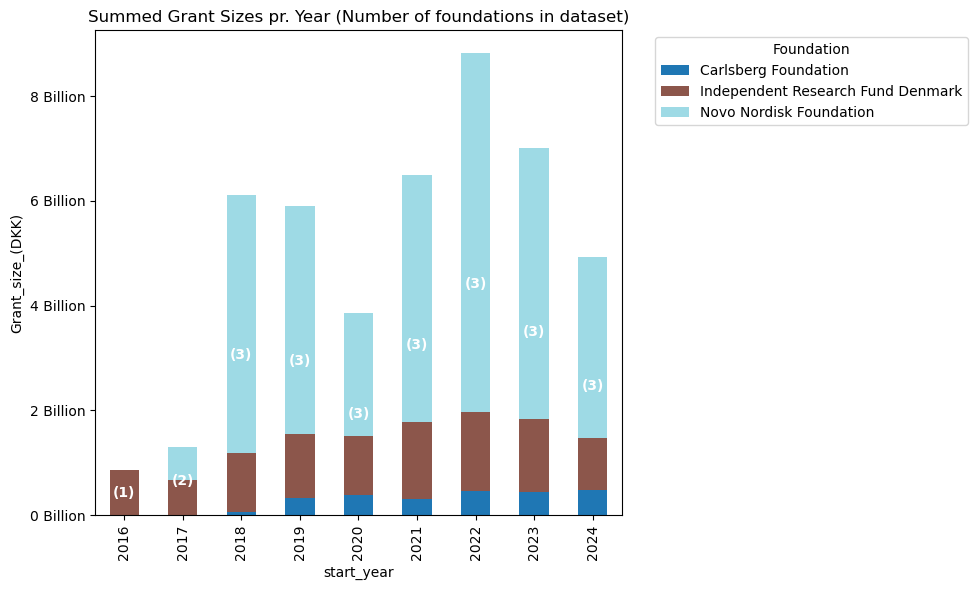

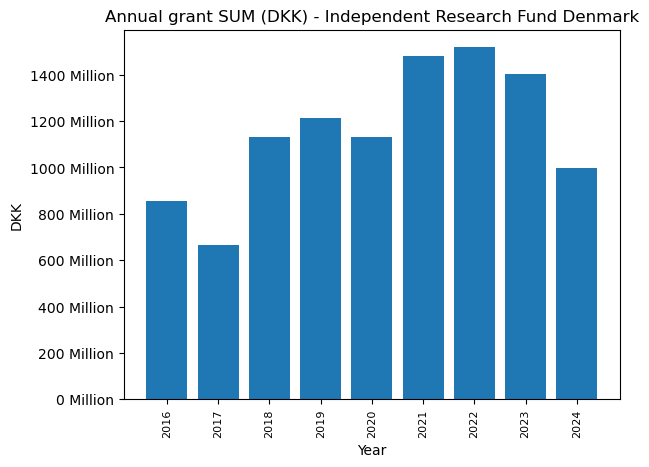

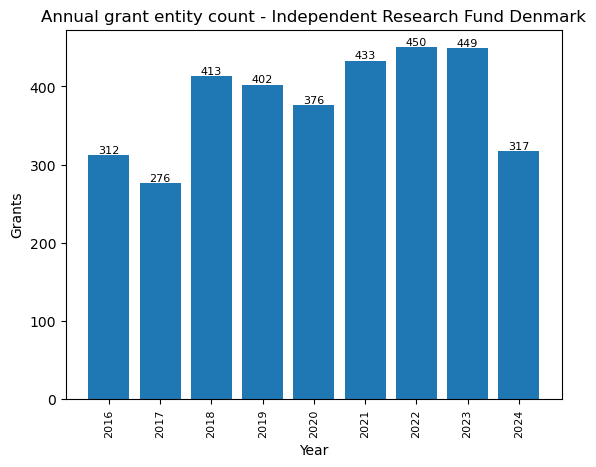

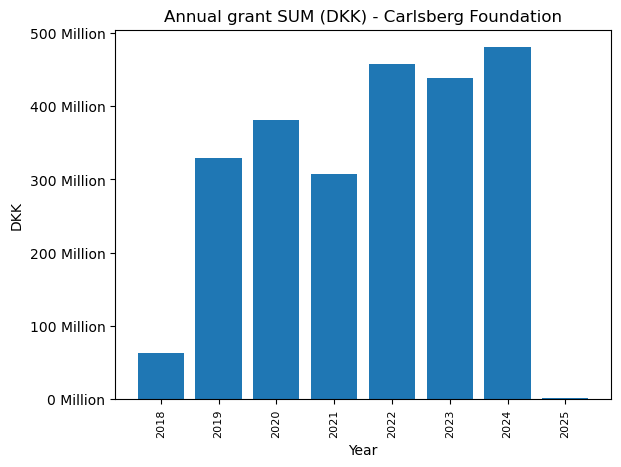

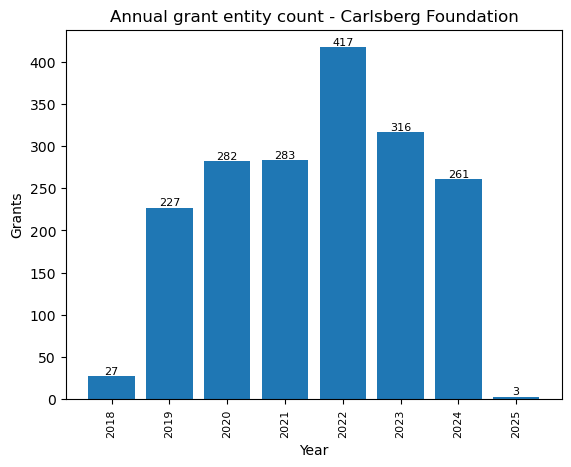

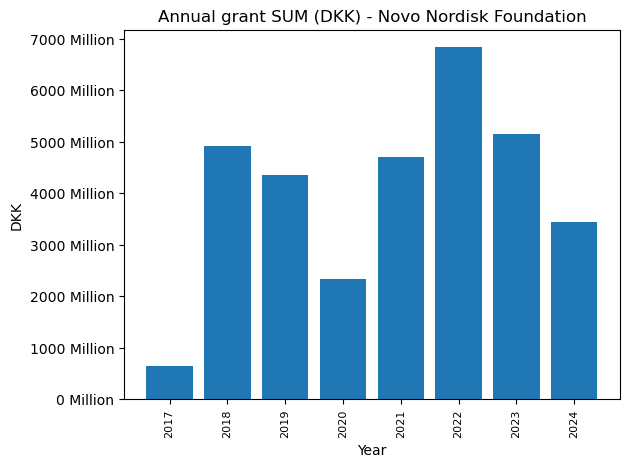

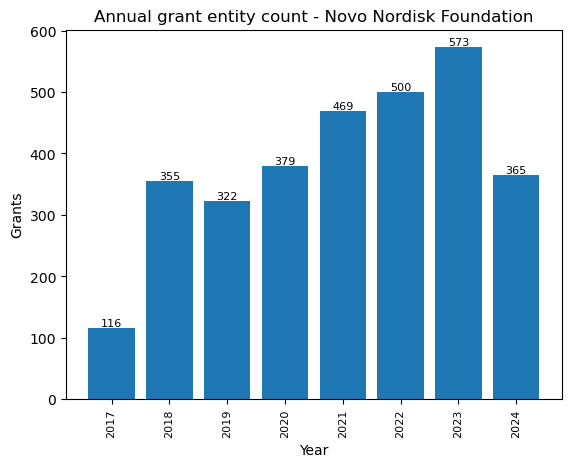

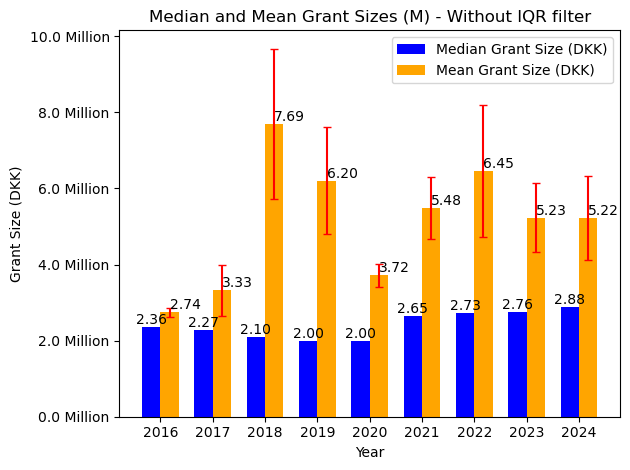

2016 - Upper Bound: 5289565.75, Outliers removed Count: 58
2017 - Upper Bound: 6647412.5, Outliers removed Count: 13
2018 - Upper Bound: 7454131.25, Outliers removed Count: 63
2019 - Upper Bound: 8122556.25, Outliers removed Count: 85
2020 - Upper Bound: 8386325.0, Outliers removed Count: 88
2021 - Upper Bound: 11279022.0, Outliers removed Count: 63
2022 - Upper Bound: 10691408.75, Outliers removed Count: 79
2023 - Upper Bound: 9307480.0, Outliers removed Count: 127
2024 - Upper Bound: 9553242.5, Outliers removed Count: 78


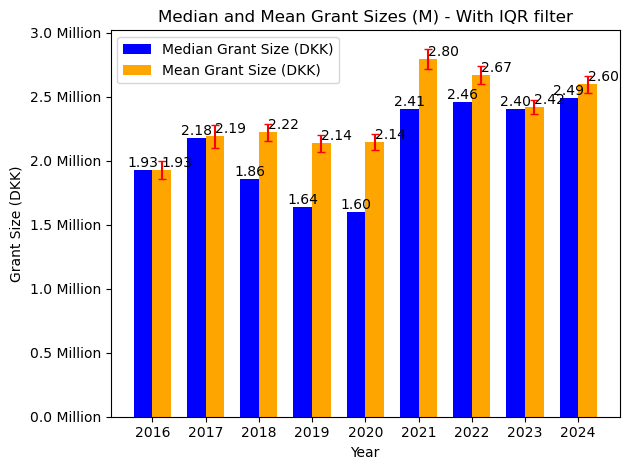

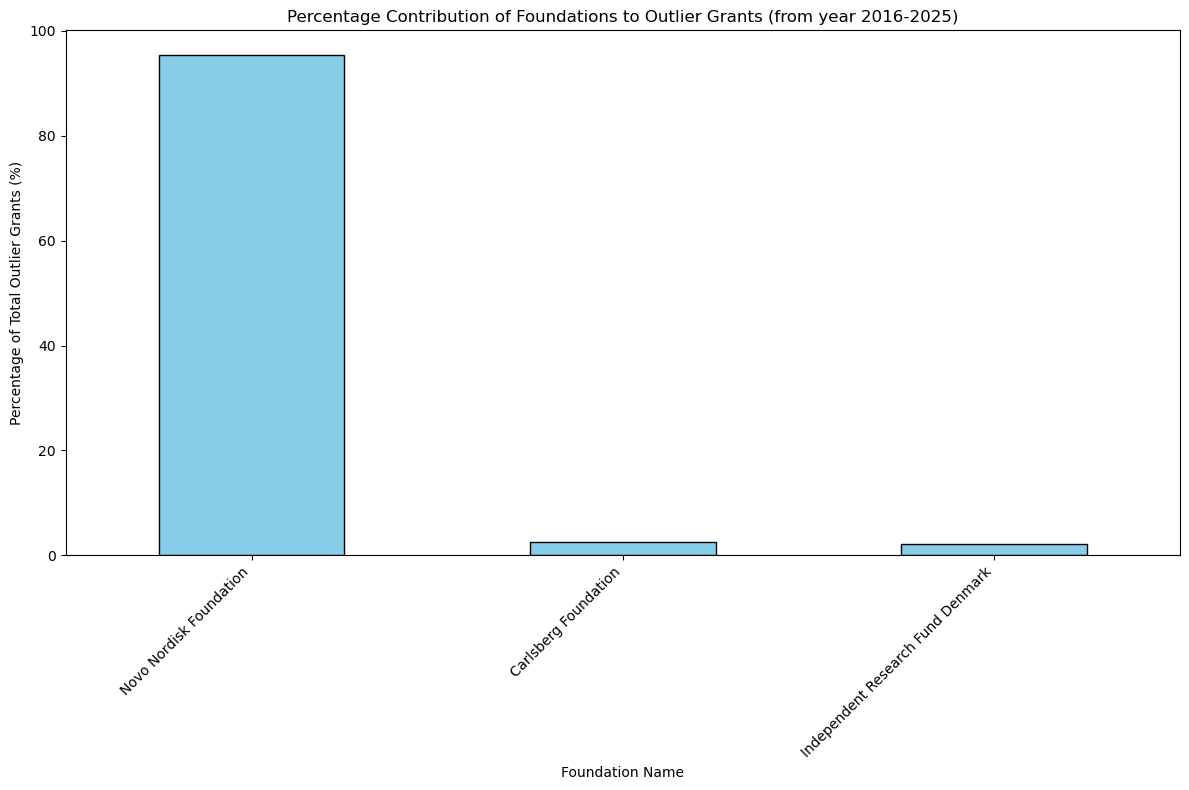

In [5]:
#Chapter 1 running code:


# Making "start year" column
df["start_year"] = df["date"].apply(lambda x: x.get("start"))
df["start_year"] = df["start_year"].str.slice(0,4)
df["start_year"] = df["start_year"].astype("Int64")
year_min = df["start_year"].min()
year_max = df["start_year"].max()

#only 8 grants in 2025 = remove! 

# Making "funder" column
df["foundation"] = df["funder"].apply(lambda x: x.get("name"))

#1
grant_counter(year_min, year_max-1, df, "Grant_entity_count")

#2
grant_sum_fund_sum(year_min, year_max-1, df, "grant_sum_stacked")

#3 
pr_foundation_grantsum(df)

#4
means_and_median(year_min, year_max-1, df, "means_median", "Without IQR filter")

#5
df_no_outlier, outl_list = outlier_detecter(year_min, year_max-1, df)

#6
means_and_median(year_min, year_max-1, df_no_outlier, "means_median", "With IQR filter")

#6
outlier_contributer_combined(outl_list, "out")


#fingerprint for each abstact


In [6]:
_ = ts.preaccelerate_and_speedtest()

Preacceleration-Process will take a few minutes.
Tips: The smaller `timeout` value, the fewer translators pass the test and the less time it takes to preaccelerate. However, the slow speed of preacceleration does not mean the slow speed of later translation.

Preacceleration Process: 100%|██████████████████| 37/37 [06:00<00:00,  9.75s/it]


SpeedTest-Process will take a few seconds.

SpeedTest Process:  32%|███████▉                 | 6/19 [00:04<00:10,  1.30it/s]TimeSpent(function: google): 0.09s
TimeSpent(function: hujiang): 1.05s
SpeedTest Process: 100%|████████████████████████| 19/19 [00:14<00:00,  1.34it/s]


In [7]:
#Translations Running Code


#Running code - abstract
language_detected_abstract = detection_fun(df.abstract)

df["abstract"].astype(str)
abstract_translate_index, nan_abstract = language_abstract_detect_parser(language_detected_abstract)

#abstract translation
ts_abstract, not_ts, not_ts_index = translater_function(df.abstract, abstract_translate_index)




0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400


In [8]:
#Continuing

ts_abstract
ts_abstract_se = pd.Series(ts_abstract)
df.abstract.iloc[abstract_translate_index] = ts_abstract_se

/var/folders/cn/n534_4n13g5gcvffdw0b21mh0000gn/T/ipykernel_55470/3561175878.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.abstract.iloc[abstract_translate_index] = ts_abstract_se


In [12]:


# run text cleanse

df_cleaned = clean_column(df)

df_no_stemming = clean_column_no_stem(df)

df_cleaned.to_csv("18_march_df_cleaned_translated_abstracts.csv")
df_no_stemming.to_csv("18_march_df_clean_translate_nostem.csv")